In [2]:
import os
import sys
project_root = os.path.abspath("c:/Users/alireza/Desktop/souri/souri/bargh")
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_selector import Feature_selector
from logs.logger import CustomLogger
from models import Random_Forest, Linear
import src.root

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

*************************
c:\Users\alireza\Desktop\souri\souri\bargh\logs


In [ ]:
def select_dict(df,goup, features_to_drop=None):
        if features_to_drop is not None:
            df.drop(columns=features_to_drop, axis=1, inplace=True)
        
        df_dict = {k: v.drop(columns=goup) for k, v in df.groupby(goup)}
        
        X_dict = {}
        y_dict = {}
        
        for k in df_dict:
            v_df = df_dict[k]
            categorical_cols = v_df.select_dtypes(include=['object', 'category']).columns
            dfl = pd.get_dummies(v_df, columns=categorical_cols, drop_first=True).dropna()
            if not dfl.empty:
                X_dict[k] = dfl.drop(columns=["generation"])
                y_dict[k] = dfl["generation"]

        logger.debug(f"Features training is applied on: {df.columns}")

        return X_dict, y_dict
    
df = pd.read_csv(get_root() +"/data/processed/operation.csv", encoding='utf-8')
df_modified = Data_selector(df).select()

feature_to_be_dropped = ['id', 'hour', 'date', 'status', 'declare','wind_direction']
print(type(df_modified))
X, y = select_dict(df_modified,["name","code"],feature_to_be_dropped)

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# میانگین تولید هر نیروگاه با حذف کردن ساده داده های پرت
df = pd.read_csv(get_root() +"/data/processed/operation.csv", encoding='utf-8').dropna()
df = Data_selector(df).select() # داده های پرت تولید حذف شد
print(df.groupby(["name","code"])["generation"].mean())
#feature_to_be_dropped = ['id', 'hour', 'date', 'status', 'declare','wind_direction']
#print(type(df_modified))
#X, y = select(df_modified,["name","code"],feature_to_be_dropped)

name                   code
جنوب اصفهان - چهلستون  G11     108.695054
                       G12     108.760619
                       G13     112.428920
                       G14     106.061816
                       G15     108.264187
                       G16     111.055634
حافظ                   G11     110.594885
                       G12     109.590864
                       G13     108.613693
                       G14     110.199237
                       G15     108.989411
                       G16     108.315179
سبلان                  G11     119.779684
                       G12     116.022871
                       G13     112.827199
                       G14     112.393560
                       G15     116.746726
                       G16     116.814167
                       S1      137.495402
سیکل ترکیبی ارومیه     G11     126.398276
                       G12     122.483582
                       G13     112.690523
                       G14     112.471007
      

In [ ]:
import numpy as np
df = pd.read_csv(get_root() +"/data/processed/operation.csv", encoding='utf-8').dropna()
#df = Data_selector(df).select() # داده های پرت تولید حذف شد
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
df["name"].unique()

array(['پرند', 'شهدای پیروز - بهبهان', 'جنوب اصفهان - چهلستون', 'سبلان',
       'سیکل ترکیبی ارومیه', 'سیکل ترکیبی یزد', 'سیکل ترکیبی شیروان',
       'عسلویه', 'حافظ'], dtype=object)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def get_dphase(t1s,t2s,flag=False):
    t1 = pd.to_datetime(t1s)
    t2 = pd.to_datetime(t2s)
    t0 = t1 - np.timedelta64(12,'h')
    pick_df = df_i[(df_i['datetime'] >= t1) & (df_i['datetime'] <= t2)]["generation"]
    tmep_df = df_i[(df_i['datetime'] >= t0) & (df_i['datetime'] <= t2)]["temperature"]
    time_df = df_i[(df_i['datetime'] >= t0) & (df_i['datetime'] <= t2)]["datetime"]

    a1 = pick_df.to_numpy()
    a2 = tmep_df.to_numpy()
    a3 = time_df.to_numpy()
    lv = []
    m1 = np.mean(a1)
    for i in range(0,len(a2)-len(a1)):
        m2 = np.mean(a2[-(i+1):-(i+len(a1)):-1])
        lv.append(sum(  (a1[-(k+1)]-m1)  *  (a2[-(i+k+1)]-m2) for k in range(len(a1))))
    lv = np.array(lv)
    #lv = np.convolve(a2[::-1],a1)[len(a1)-1:]
    n = len(a2)-len(a1)
    time = np.arange(0,n)
    if flag:
        plt.plot(time,lv)
        plt.show()
        print(lv[:n].argmin())
    #if lv.argmin() == 6:
        #print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^",t1s,lv,n,len(a1),len(a2))
    return lv.argmin(),lv

df_i = df[(df["name"] == "پرند") & (df["code"] == "G13")].dropna()
'''
times_pick = [(f"2023-{7}-{13} 14:00",f'2023-{7}-{14} 22:00'),
              (f"2023-{7}-{18} 14:00",f'2023-{7}-{19} 22:00'),
              (f"2023-{7}-{20} 14:00",f'2023-{7}-{21} 22:00')]
times_pick = [(f"2022-{i}-{j} 14:00",f'2022-{i}-{j+1} 22:00') for i in range(6,10) for j in range(1,25,2)] + []
'''
times_pick = []
for date in df_i["date"].unique():
    date1 = date + np.timedelta64(14,'h')
    date2 = date + np.timedelta64(22,'h')  
    times_pick.append((date1,date2))
    
d_get_dphase = []
sum_lv = [[0 for i in range(12)] for i in range(12)]

for s1,s2 in times_pick:
    st = df_i[df_i["datetime"] == s1][["status","value"]]
    x,lv = get_dphase(s1,s2)
    d_get_dphase.append(x)
    # sum_lv[x] += lv
    # if x in [2,3] : get_dphase(s1,s2,True)#print(s1,s2,st.iat[0,0],st.iat[0,1],"->",get_dphase(s1,s2,True))

In [7]:
a,b = np.unique(np.array(d_get_dphase), return_counts=True)
for i in range(len(a)):
   print(a[i],b[i])

0 45
1 39
2 62
3 91
4 83
5 47
6 18
7 10
8 6
9 11
10 22
11 83


انتخاب پیک ها - بررسی پشت هم بودن - بررسی نرم بودن - نمایش نرم ها و غیر نرم ها

In [ ]:
df_ii = df_i[((df_i['status'] == 'SO') | (df_i['status'] == 'LF1'))]
df_ii = df_ii[(df_ii['value'] == 'P')]
b = df_ii['hour'].unique().tolist()
b.sort()
print(b)

[14, 15, 16, 17, 18, 19, 20, 21, 22]


In [36]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def is_smooth_array(data,threshold,f_show = False):
    x = data["hour"].to_numpy()  # Your x-values
    y = data["generation"].to_numpy()  # Your y-values
    window_length = min(51, len(y) - 1 + len(y)%2)  # window size, must be odd, adjust for your data
    
    #print(data,x,y,len(x),window_length)
    polyorder = 2  # polynomial order
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

    # Compute residual noise
    flac = abs(y-y.mean())
    residuals = y - y_smooth
    noise_std = np.std(residuals)

    # Optional: Visualize
    if f_show:
        plt.plot(x, y, label='Raw data')
        plt.plot(x, y_smooth, label='Smoothed curve')
        plt.legend()
        plt.show()

    #print(f"Noise standard deviation: {noise_std}")
    if noise_std < threshold:  # threshold is your chosen value for smoothness
        pass#print("Data is smooth!")
        return noise_std,True,np.var(np.diff(y, n=1))#flac#residuals
    else:
        pass#print("Data is noisy!")
        return noise_std,False,np.var(np.diff(y, n=1))#flac#residuals

def is_smooth(date,data_var,data_date,threshold,log={True:np.array([0,0,0,0,0],dtype=float),False:np.array([0,0,0,0,0],dtype=float)},flag=False):
    date1 = date + np.timedelta64(0,'h')
    date2 = date + np.timedelta64(24,'h')
    temp = df_i[(df_i['datetime'] > date1) & (df_i['datetime'] <= date2) & ((df_i['value'] == 'P'))][["hour","generation","datetime"]]
    p_hours = temp["hour"].to_numpy()
    if len(p_hours) in [5]:
        x,f,re = is_smooth_array(temp,threshold,flag)
        log[f] += re
        if f:
            data_var.append(x)
            data_date.append(temp["datetime"])
            return 1,1
        return 1,0
    return 0,0

def is_co(date,log):
    date1 = date + np.timedelta64(0,'h')
    date2 = date + np.timedelta64(24,'h')
    temp = df_i[(df_i['datetime'] > date1) & (df_i['datetime'] <= date2) & ((df_i['value'] == 'P'))][["hour","generation"]]
    p_hours = temp["hour"].to_numpy()
    f = (np.diff(np.sort(p_hours)) == 1).all()
    if f:
        log.append(len(p_hours))
    return f

In [37]:
df_i = df[(df["name"] == "پرند") & (df["code"] == "G11")].dropna()
all_date = df_i["date"].unique()

log = []
for date in all_date:
    is_co(date,log)
pi,fr = np.unique(np.array(log),return_counts=True)
for i in range(len(pi)) : print(pi[i],fr[i])

2 246
4 687
5 495


In [40]:
data_var = []
data_date = []
log = {True:np.array([0,0,0,0,0],dtype=float),False:np.array([0,0,0,0,0],dtype=float)}
t = 0
n = 0
threshold = 0.3

for date in all_date:
    nn,tt = is_smooth(date,data_var,data_date,threshold,log=log)
    n += nn
    t += tt

log[True] /= (t)
log[False] /= (n-t)
print(t/n*100)
print(log)

83.83838383838383
{True: array([0.27093021, 0.27093021, 0.27093021, 0.27093021, 0.27093021]), False: array([7.34911492, 7.34911492, 7.34911492, 7.34911492, 7.34911492])}


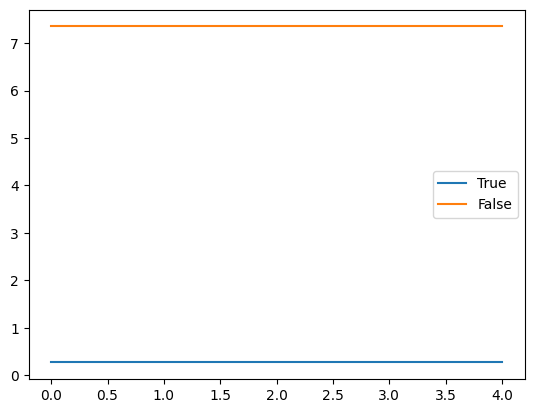

In [39]:
plt.plot(log[True],label = 'True')
plt.plot(log[False],label = 'False')
plt.legend()
plt.show()

2022-08-01


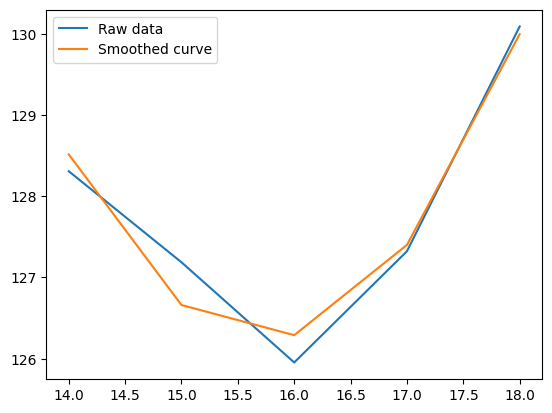

2022-08-01


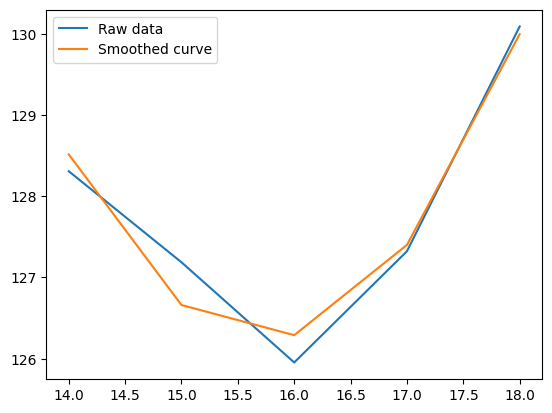

2022-08-01


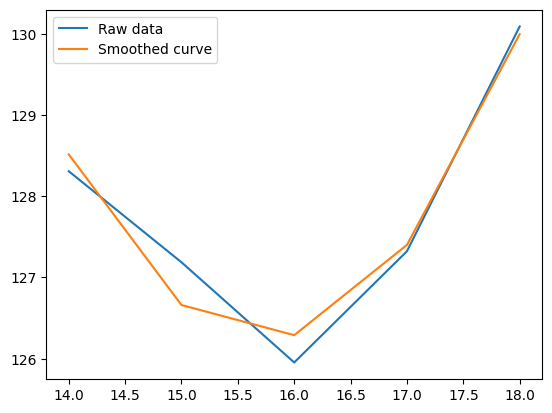

2022-08-01


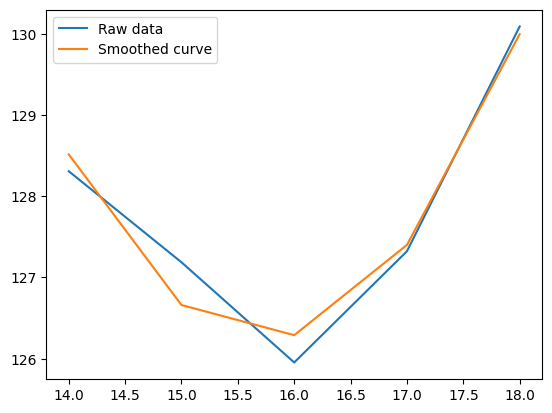

2022-08-01


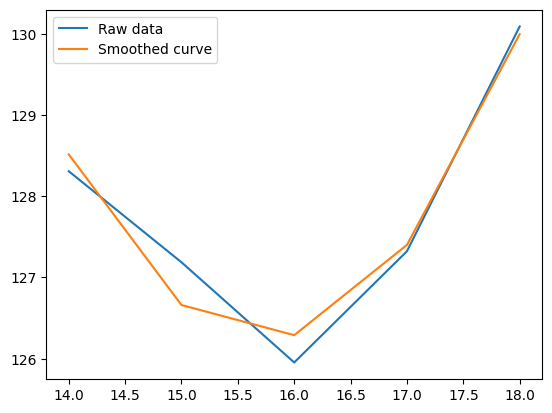

In [41]:
k = 2
b = []
data_var = np.array(data_var)
data_date = np.array(data_date)
k_largest = data_var.argsort()[-k:]
for date in data_date[k_largest][0].astype('datetime64[D]'):
    print(date)
    is_smooth(date,b,[],threshold,flag=True)

1

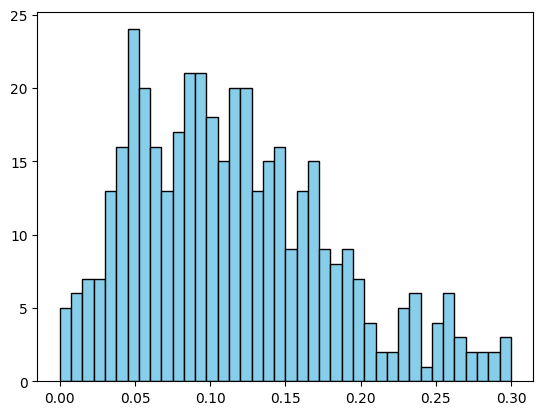

In [42]:
plt.hist(data_var, bins=40, color='skyblue', edgecolor='black')
1

In [ ]:
df_only = pd.read_csv(get_root() +'/data/processed/prediction.csv', encoding='utf-8')

In [241]:
df_only["is_good_pick"] = False

In [242]:
data_date1 = [date for dates in data_date for date in dates ]
len(data_date1)

875

In [248]:
df_only['datetime'] = pd.to_datetime(df_only['date']) + pd.to_timedelta(df_only['hour'], unit='h')
flag_array = (df_only["name"] == "پرند") & (df_only["code"] == "G13") & df_only["datetime"].isin(data_date1)
df_only.loc[flag_array,"is_good_pick"] = True

In [ ]:
df_only.to_csv(path_or_buf=get_root() +'/data/processed/prediction_only.csv', sep=',', header=True, index=False,na_rep='NULL')

In [17]:
len(all_date),len(data_date)

(517, 175)